In [ ]:
from kan import *
import pandas as pd
import torch
import numpy as np
import torch.nn.functional as F
torch.set_default_dtype(torch.float64)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

from sklearn.preprocessing import StandardScaler, label_binarize
import matplotlib.pyplot as plt 

X_columns = [
    'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 
    # 'Drate',
    # 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    # 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count',
    # 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
    # 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 
    'IPv','LLC', 
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
    'Magnitue', 'Radius', 'Covariance',
    # 'Variance', 'Weight'
]
Y_columns = ['label_L1']

label_L1_mapping = {"MQTT": 0, "Benign": 1, "Recon": 2, "ARP_Spoofing": 3}
label_L2_mapping = {"MQTT-DDoS-Connect_Flood": 4, "MQTT-DDoS-Publish_Flood": 5, 
                    "MQTT-DoS-Connect_Flood": 6, "MQTT-DoS-Publish_Flood": 7,
                    "MQTT-Malformed_Data": 8, "benign": 9, 
                    "Recon-OS_Scan": 10, "Recon-Port_Scan": 11,
                    "arp_spoofing": 12}

# Read the CSV file
df = pd.read_csv('/home/zyang44/Github/baseline_cicIOT/CIC_IoMT/19classes/filtered_train_l_4_11.csv')
label_mapping = {'ARP_Spoofing': 0, 'Benign': 1, 'MQTT': 2, 'Recon': 3, 'TCP_IP-DDOS': 4, 'TCP_IP-DOS': 5}
df['label_L1'] = df['label_L1'].map(label_L1_mapping)
df['label_L2'] = df['label_L2'].map(label_L2_mapping)

# Shuffle the dataframe before splitting into training and test sets
df = df.sample(frac=1, random_state=42)
# 90% as training set and 10% as test set
train_size = int(len(df) * 0.9)
train_df, test_df = df.iloc[:train_size, :], df.iloc[train_size:, :]

# 使用 StandardScaler 对数据进行缩放
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_df)
test_data_scaled = scaler.transform(test_df)


scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[X_columns])
test_X_scaled = scaler.transform(test_df[X_columns])
train_y = train_df[Y_columns].values.ravel()
test_y = test_df[Y_columns].values.ravel()

# take Y_columns as the label, and transfering to one-hot coded
dataset = {
    'train_input': torch.tensor(train_X_scaled, dtype=torch.float64, device=device),
    'train_label': F.one_hot(torch.tensor(train_y, dtype=torch.long, device=device), num_classes=4),
    'test_input': torch.tensor(test_X_scaled, dtype=torch.float64, device=device),
    'test_label': F.one_hot(torch.tensor(test_y, dtype=torch.long, device=device), num_classes=4)
}
print("Data prepared.",
      f"Train set: {dataset['train_input'].shape, dataset['train_label'].shape}",
      f"Test set: {dataset['test_input'].shape, dataset['test_label'].shape}", sep="\n")

cuda:0
Data prepared.
Train set: (torch.Size([89918, 20]), torch.Size([89918, 4]))
Test set: (torch.Size([9991, 20]), torch.Size([9991, 4]))


In [2]:
# Check for NaN or infinite values in dataset
print("NaN values in dataset:", np.isnan(train_data_scaled).any())
print("Infinite values in dataset:", np.isinf(test_data_scaled).any())

NaN values in dataset: True
Infinite values in dataset: False


checkpoint directory created: ./model
saving model version 0.0


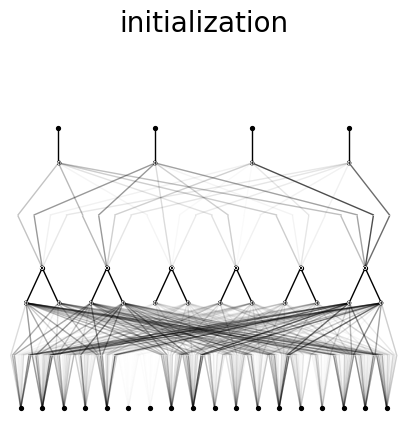

In [39]:
model = KAN(width=[18,[0,6],4], grid=5, k=3, seed=2, device=device)
# plot KAN at initialization
model(dataset['train_input'])
model.plot(title='initialization')

description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 3.29e+01 | test_loss: 3.40e+01 | reg: 4.61e+02 | : 100%|█| 100/100 [00:15<00:00,  6.32


saving model version 0.1
saving model version 0.2


| train_loss: 5.90e+00 | test_loss: 5.52e+00 | reg: 1.24e+03 | : 100%|█| 100/100 [00:15<00:00,  6.35


saving model version 0.3


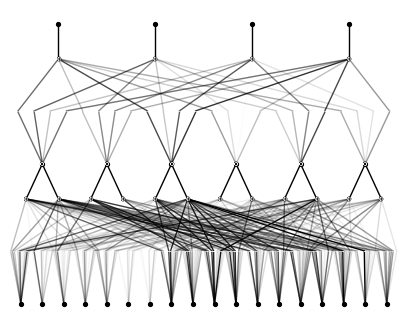

In [25]:
model.fit(dataset, opt="Adam", steps=100)
model = model.prune()
model.fit(dataset, opt="Adam", steps=100)
model.plot()

In [ ]:
model.attribute(1,0)
model.attribute(1,1)
model.attribute(1,2)
model.attribute(1,3)

In [30]:
model.attribute()
model.feature_score
model.edge_scores

[tensor([[0.0850, 0.0117, 0.0406, 0.0392, 0.1002, 0.0158, 0.0070, 0.2293, 0.0458,
          0.0577, 0.0998, 0.0566, 0.0962, 0.3146, 0.2429, 0.0321, 0.0561, 0.0606],
         [0.1309, 0.2317, 0.0987, 0.1032, 0.1030, 0.0000, 0.0115, 0.0711, 0.0483,
          0.2758, 0.0737, 0.3135, 0.1773, 0.2183, 0.1426, 0.1388, 0.1056, 0.1498],
         [0.0733, 0.0000, 0.1930, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3459,
          0.2074, 0.3905, 0.0000, 0.0000, 0.0000, 0.3402, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3335,
          0.0000, 0.0628, 0.0000, 0.1227, 0.0000, 0.0000, 0.1413, 0.0000, 0.0000],
         [0.0646, 0.0000, 0.0116, 0.0305, 0.0306, 0.0000, 0.0000, 0.3028, 0.1249,
          0.3803, 0.3432, 0.1612, 0.1189, 0.0613, 0.0620, 0.1828, 0.0000, 0.1091],
         [0.2315, 0.0860, 0.0272, 0.1360, 0.1377, 0.0418, 0.0392, 0.3885, 0.1416,
          0.4635, 0.4127, 0.2902, 0.2835, 0.0935, 0.1581, 0.6998, 1.2013, 0.1735],
         [

In [31]:
model.node_scores

[tensor([1.0421, 0.4678, 0.4882, 0.4956, 0.5424, 0.1468, 0.1382, 1.4485, 1.3250,
         2.1105, 1.6969, 1.1411, 1.2638, 1.2951, 1.3127, 1.6327, 1.6437, 0.9379],
        device='cuda:0', grad_fn=<MeanBackward1>),
 tensor([0.7457, 0.5222, 0.9933, 0.2692, 0.6411, 0.3472], device='cuda:0',
        grad_fn=<MeanBackward1>),
 tensor([0.2500, 0.2500, 0.2500, 0.2500], grad_fn=<MeanBackward1>)]

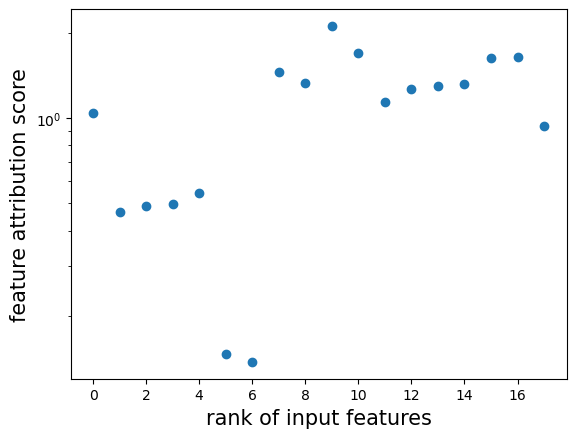

In [38]:
import matplotlib.ticker as ticker

plt.scatter(np.arange(model.feature_score.cpu().detach().numpy().shape[0]), model.feature_score.cpu().detach().numpy())
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('rank of input features', fontsize=15)
plt.ylabel('feature attribution score', fontsize=15)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

In [40]:
model = model.prune_input(threshold=0.1)

keep: [True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True]
saving model version 0.1
